# Notebook 2 - Experimenting with g-computation / s-learner


In [ ]:
!apt-get install graphviz
!pip install matplotlib pandas sklearn pydot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

%matplotlib inline

For this notebook we're going to be working with a semi-simulated dataset relating to customer churn at a cell phone company. The dataset is structured such that each row corresponds to a unique customer. We'll be working with contains the following columns:

**customer_id**: Unique primary key for each individual in the dataset

**region**: Which region in the United States does the customer live in?

**acct_length**: How many days has the customer been active for?

**internation_plan**: Does the customer have the international plan enabled?

**voicemail_plan**: Does the customer have the voicemail plan enabled?

**daytime_call_mins**: What is the total number of daytime call minutes the user has had?

**evening_call_mins**: What is the total number of evening time call minutes the user has had?	

**nighttime_call_mins**: What is the total number of nighttime call minutes the user has had?	

**customer_service_calls**: How many customer service calls has the user made?

**churn**: Did the customer quit the service?

**age**: What is the age of the user (in years)?


The company is proposing rolling out the international plan to all customers, and increasing base plan prices across the board. To help understand the effects of this plan, they want to carry out an analysis to understand the causal effect of the international plan on the probability churn in this population. So in this case, the "treatment" is the presence of that phone plan, the outcome is the churn flag.

As far as confounders we'll control for, let's say you have a whiteboarding session with the business team and collectively you decide the following causal DAG is a decent representation of how the variables in this dataset relate to each other:

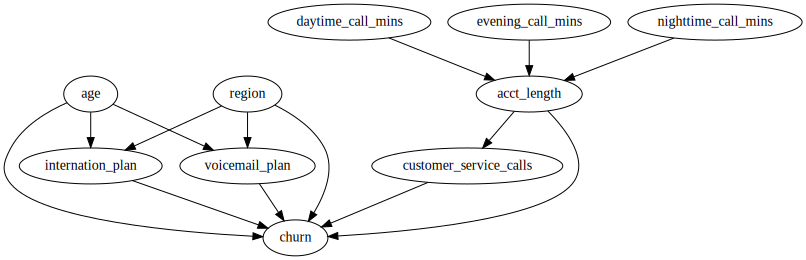

In [ ]:
g = Digraph('churn_causality')
g.edge('internation_plan', 'churn')
g.edge('age', 'churn')
g.edge('region', 'churn')
g.edge('customer_service_calls', 'churn')
g.edge('acct_length', 'customer_service_calls')
g.edge('daytime_call_mins', 'acct_length')
g.edge('evening_call_mins', 'acct_length')
g.edge('nighttime_call_mins', 'acct_length')
g.edge('voicemail_plan', 'churn')
g.edge('age', 'internation_plan')
g.edge('age', 'voicemail_plan')
g.edge('region', 'internation_plan')
g.edge('region', 'voicemail_plan')
g.edge('acct_length', 'churn')
g

Based on this above causal DAG, there are only two obvious confounders of the international plan - churn relationship: age and region. So these are the only two covariates we'll plan on controlling for.  

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ronikobrosly/misc_dataset/main/causal_churn.csv")
df.head()

,customer_id,region,acct_length,internation_plan,voicemail_plan,daytime_call_mins,evening_call_mins,nighttime_call_mins,customer_service_calls,churn,age
0,0,West North Central,128.0,no,yes,265.1,197.4,244.7,1.0,0,54
1,1,East North Central,107.0,no,yes,161.6,195.5,254.4,1.0,0,47
2,2,Middle Atlantic,137.0,no,no,243.4,121.2,162.6,0.0,0,48
3,3,East North Central,84.0,yes,no,299.4,61.9,196.9,2.0,0,57
4,4,West South Central,75.0,yes,no,166.7,148.3,186.9,3.0,0,40


### First, let's clean up the data a bit

In [ ]:
# Let's scale our continuous or close to continuous covariates
features = df[['acct_length', 'daytime_call_mins', 'evening_call_mins', 'nighttime_call_mins', 'age']]

# Use scaler of choice; here Standard scaler is used
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

df[['acct_length', 'daytime_call_mins', 'evening_call_mins', 'nighttime_call_mins', 'age']] = features

In [ ]:
# We'll convert the `region`, `internation_plan`, `voicemail_plan`, and `customer_service_calls` columns into categorical columns

df2 = pd.concat(
    [
        df[["churn", "age", "acct_length", "daytime_call_mins", "evening_call_mins", "nighttime_call_mins"]],
        pd.get_dummies(df["region"], prefix = "region"),
        pd.get_dummies(df["internation_plan"], prefix = "int_plan"),
        pd.get_dummies(df["voicemail_plan"], prefix = "vm_plan"),
        pd.qcut(df['customer_service_calls'], 2, labels=[0, 1]) # let's just split this at the median (low vs high)
    ],
    axis = 1
)



In [ ]:
# Now we can drop necessary columns (i.e. one reference column from each dummy variable group)
df2.drop(columns = ["region_East North Central", "int_plan_no", "vm_plan_no"], inplace = True)


### First, let's train a predictive model with scikit-learn. This model should take in the treatment variable and covariates, and predict the outcome variable (i.e. `churn`)

If you're curious about how well the model performs that's probably a good thing to be curious about. Let's split our small dataset into test and training sets. Now, admittedly, we have a tiny dataset, but we're doing this to show that standard ML evaluation methods are still relevant here.


In [ ]:
train_df, test_df = train_test_split(df2, test_size = 0.25, random_state = 512)

You can use any sort of model you'd like (from simple linear ones to very complex ones)

In [ ]:
features = [
    'age', 'region_East South Central',
    'region_Middle Atlantic', 'region_Mountain', 'region_New England',
    'region_Pacific', 'region_South Atlantic', 'region_West North Central',
    'region_West South Central', 'int_plan_yes', 
]

In [ ]:
temp_model = GradientBoostingClassifier(random_state = 512).fit(X = train_df[features], y = train_df['churn'])

In [ ]:
print(classification_report(y_true = temp_model.predict(test_df[features]).reshape(-1,1), y_pred = test_df['churn'].values.reshape(-1,1)))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       796
           1       0.12      0.47      0.19        30

    accuracy                           0.85       826
   macro avg       0.55      0.67      0.55       826
weighted avg       0.95      0.85      0.89       826



You could compare different model types here to see which performs best in your hold-out set. As you might expect, you'll want a model that performs well for both classes, so that we can make good inferences.

The metrics for the "churned" class in this example look awful (even if the overall model accuracy seems good on the surface), however, because this is just a demonstration so we'll continue moving forward. Let's now train on the whole dataset.

### <b>EXERCISE</b>

<b> Train a classification model using the full set of data (training + test sets combined). </b>


In [ ]:
model = GradientBoostingClassifier(random_state = 512).fit(X = df2[features], y = df2['churn'])

## Now that we have a model we can start making predictions to see counterfactual outcomes

### <b>EXERCISE</b>

<b> Take the full dataset and "force" everyone to have received the treatment, what is the mean probability of all individuals to have churned? </b>


In [ ]:
df_treat = df2.copy()
df_treat['int_plan_yes'] = 1

In [ ]:
# Verifying that everyone is "receiving the treatment"
df_treat['int_plan_yes'].value_counts()

1    3304
Name: int_plan_yes, dtype: int64

In [ ]:
# Let's get the probability of churn from these predictions
treat_churn_prob = model.predict_proba(df_treat[features])[:,1].mean()
print(f"Mean probability of churning in this hypothetical treatment population is {round(treat_churn_prob, 3)}")

Mean probability of churning in this hypothetical treatment population is 0.397


### <b>EXERCISE</b>

<b> Take the full dataset and "force" everyone to have NOT received the treatment, what is the mean probability of all individuals to have churned? </b>


In [ ]:
df_ctrl = df2.copy()
df_ctrl['int_plan_yes'] = 0

In [ ]:
# Verifying that nobody is "receiving the treatment"
df_ctrl['int_plan_yes'].value_counts()

0    3304
Name: int_plan_yes, dtype: int64

In [ ]:
# Let's get the probability of churn from these predictions
ctrl_churn_prob = model.predict_proba(df_ctrl[features])[:,1].mean()
print(f"Mean probability of churning in this hypothetical control population is {round(ctrl_churn_prob, 3)}")

Mean probability of churning in this hypothetical control population is 0.117


## This is a very interesting outcome. Essentially you found that enabling international calls across the board (as well as increasing the base phone plan rate to account for this), increases the probability of churning in this population by about 239% (11.7% to 39.7%)! You can think of this delta as your average treatment effect (ATE).

Now remember, one of the challenges of causal inference is with what we have at our disposal, we have no way of determining if this is correct. So there are a few possibilities at this point: 

1) We took all of the relevant data, correctly specified the causal DAG, picked the correct confounding variables to control for, and rolling out this intervention (everyone gets ability to make international calls and also sees an increase in their base phone plan price) to the whole population will cause a big uptick in churn. 

2) We have all of the relevant data, and have incorrectly specified our causal DAG and as a result picked a wrong set of covariates to control for. Better re-assess this with the domain experts.

3) We're missing critical variables in our dataset and there is unaccounted for confounding bias going on here. Can you try to brainstorm what these could be and see if you're able to bring in that data?

## You could obtain confidence intervals around this estimate by taking bootstrap replicates of the original dataset, training a new model on each replicate, and then calculating the ATE for each replicate. The 2.5th and 97.5th percentiles of these values would represent the bounds of your 95% confidence interval.

### <b>EXERCISE</b>

<b> Can you calculate the average treatment effect among the treated (ATT)? Hint: just as the metric's name suggests, you would focus exclusively on the originally treated group, and see how a receiving and not receiving the treatment among that group would play out. </b>


In [ ]:
df_treat = df2[df2["int_plan_yes"] == 1]
df_treat['int_plan_yes'] = 1
treat_churn_prob = model.predict_proba(df_treat[features])[:,1].mean()
print(f"Mean probability of churning in this hypothetical treatment population is {round(treat_churn_prob, 3)}")

Mean probability of churning in this hypothetical treatment population is 0.42


<ipython-input-68-b7e9f14b9fee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['int_plan_yes'] = 1


In [ ]:
df_ctrl = df2[df2["int_plan_yes"] == 1]
df_ctrl['int_plan_yes'] = 0
ctrl_churn_prob = model.predict_proba(df_ctrl[features])[:,1].mean()
print(f"Mean probability of churning in this hypothetical treatment population is {round(ctrl_churn_prob, 3)}")

Mean probability of churning in this hypothetical treatment population is 0.126


<ipython-input-69-29845c2a5592>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctrl['int_plan_yes'] = 0
